# EE5377 - Introduction to Image Processing

Homework-3

## Imports

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import cv2
import random
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Importing Images

Images provided are kept in a folder named Images in same directory as .ipynb file

I[0] is First Frame and I[1] is Second Frame

In [2]:
Frame1 = np.expand_dims(pimg.imread('Images/first_frame.png'),axis=0)
Frame2 = np.expand_dims(pimg.imread('Images/second_frame.png'),axis=0)

I = np.append(Frame1,Frame2,axis=0)

#### Displaying Frames

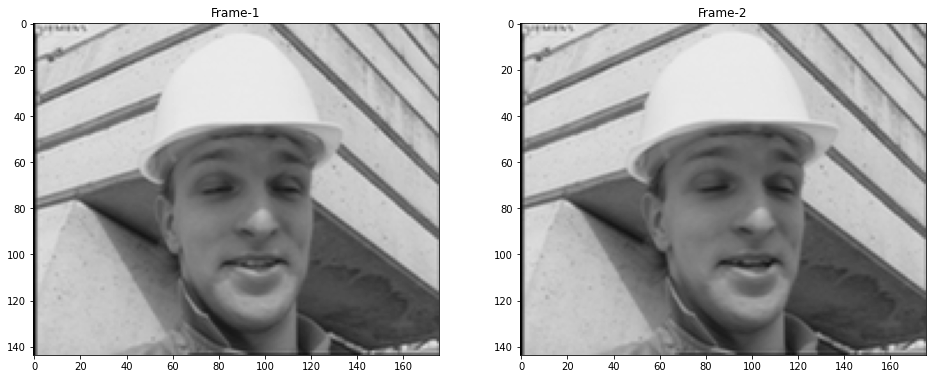

In [3]:
plt.figure(figsize=(16,16))

plt.subplot(1,2,1)
plt.imshow(I[0],cmap='gray')
plt.title("Frame-1")

plt.subplot(1,2,2)
plt.imshow(I[1],cmap='gray')
plt.title("Frame-2")

plt.show()

## Motion Estimator

### Mean Absolute Distance between 2 MacroBlocks
Function Calculates MAD of 2 MacroBlocks

In [4]:
def MAD(Block1, Block2):
    return np.mean(np.abs(Block1-Block2))

### Search Neighbourhood
Finds $(d_1,d_2)$ of each MacroBlock of Frame-2 in Frame-1

In [5]:
def SearchNeighbourhood(MacroBlock,I,p,q,Positions):
    
    Distances = {}
    for s in Positions:
        if (p+s[0])>=0 and (p+15+s[0])<I.shape[0] and (q+s[1])>=0 and (q+15+s[1])<I.shape[1]:
            Distances[s] = MAD(I[p+s[0]:p+16+s[0], q+s[1]:q+16+s[1]],MacroBlock)
            
    SD = sorted(Distances.items(), key = lambda t:(t[1], t[0]))
    
    return SD[0][0]

### Calculating $(d_1,d_2)$ of each MacroBlock of Image

MacroBlock is in I and Search is done in J. D (called Movements in other comments) consists of $(d_1, d_2)$ of each MacroBlocks

In [6]:
def MacroBlocksDistances(I,J,M,D):
    l,m = I.shape
    a,b = int(l/16),int(m/16)
    MBDist = np.zeros((a,b,2)).astype(int)
    
    Move = [-M,0,M]
    Positions = []
    for i in Move:
        for j in Move:
            Positions.append((i,j))
    
    for i in range(a):
        for j in range(b):
            p = 16*i + D[i][j][0]
            q = 16*j + D[i][j][1]
            MacroBlock = I[16*i:16*(i+1), 16*j:16*(j+1)]
            
            MBDist[i,j,:] = SearchNeighbourhood(MacroBlock,J,p,q,Positions)
            
    return MBDist

### Step-1 of Motion Estimation

$D_0$ is just matrix of zeros or can be considered as Initial Postions of MacroBlocks before **Step-1** created as Frames are passes to function **MacroBlocksDistances** Function which required a Movement Parameter as Input. $D$ is Primary used in **Steps-2,3** of Motion Estimation.

$D_1$ is the Net Movement of **MacroBlock** after **Step-1** from its **Initial Position in Frame-2 to Final Postion in Frame-1**.

In [7]:
D0 = np.zeros((int(I[1].shape[0] / 16), int(I[1].shape[1] / 16), 2)).astype(int)
D1 = MacroBlocksDistances(I[1],I[0],4,D0) + D0

### Step-2 of Motion Estimation

$D_2$ is the Net Movement of **MacroBlock** after **Step-2** from its **Initial Position in Frame-2 to Final Postion in Frame-1** which is Distance wrt D1 + D1

In [8]:
D2 = MacroBlocksDistances(I[1],I[0],2,D1) + D1

### Step-3 of Motion Estimation

$D_3$ is the Net Movement of **MacroBlock** after **Step-3** from its **Initial Position in Frame-2 to Final Postion in Frame-1** which is Distance wrt D2 + D2

In [9]:
D3 = MacroBlocksDistances(I[1],I[0],1,D2) + D2
NetD = D3

### Plotting Arrow Vector

Plotting Motion Vectors from **Frame-2 to Frame-1 for each MacroBlock**

In [10]:
x = 16*np.arange(0,11)
y = 16*np.arange(0,9)

x,y = np.meshgrid(x,y)
x = x.flatten()
y = y.flatten()
dx = NetD[:,:,1].flatten()
dy = NetD[:,:,0].flatten()

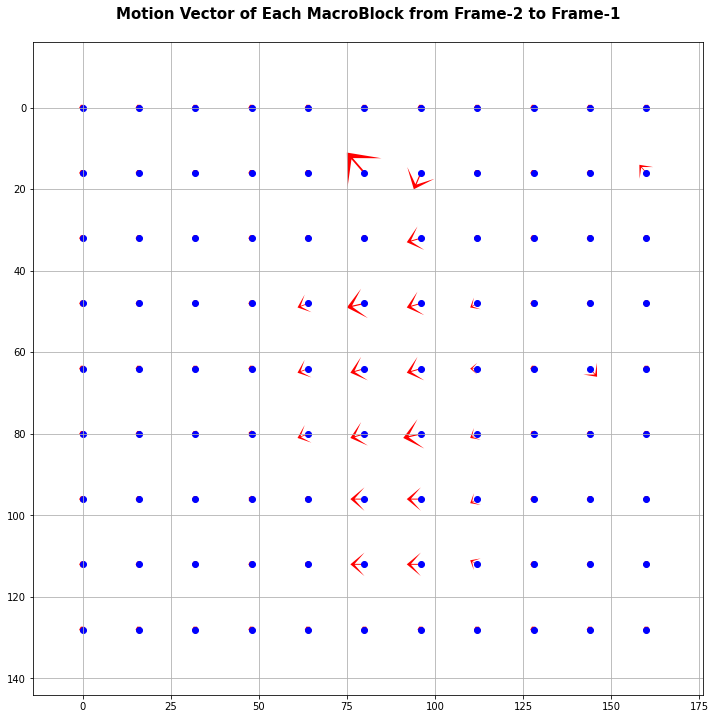

In [11]:
plt.figure(figsize=(12,12))
plt.grid()
plt.title('Motion Vector of Each MacroBlock from Frame-2 to Frame-1\n', fontsize=15, fontweight=900)
plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy',scale=1,width=0.01,headwidth=25,headlength=15,color='red')
plt.scatter(x,y,color='blue')
plt.xlim(-14, 176)
plt.ylim(144, -16)   
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True 
plt.show()

### Predicted Frame using Motion Vectors

Predicting **Second Frame** using **First Frame** and **Motion Vectors from Second Frame to First Frame**.

In [12]:
def PredictFrame(I,D):
    PredFrame = np.zeros(I.shape)
    l,m = D.shape[0:2]
    
    for i in range(l):
        for j in range(m):
            PredFrame[16*i:16*(i+1),16*j:16*(j+1)] = I[D[i][j][0] + 16*i:D[i][j][0] + 16*(i+1), D[i][j][1] + 16*j:D[i][j][1] + 16*(j+1)]
    return PredFrame

PredFrame = PredictFrame(I[0],NetD)

#### Displaying Predicted Frame

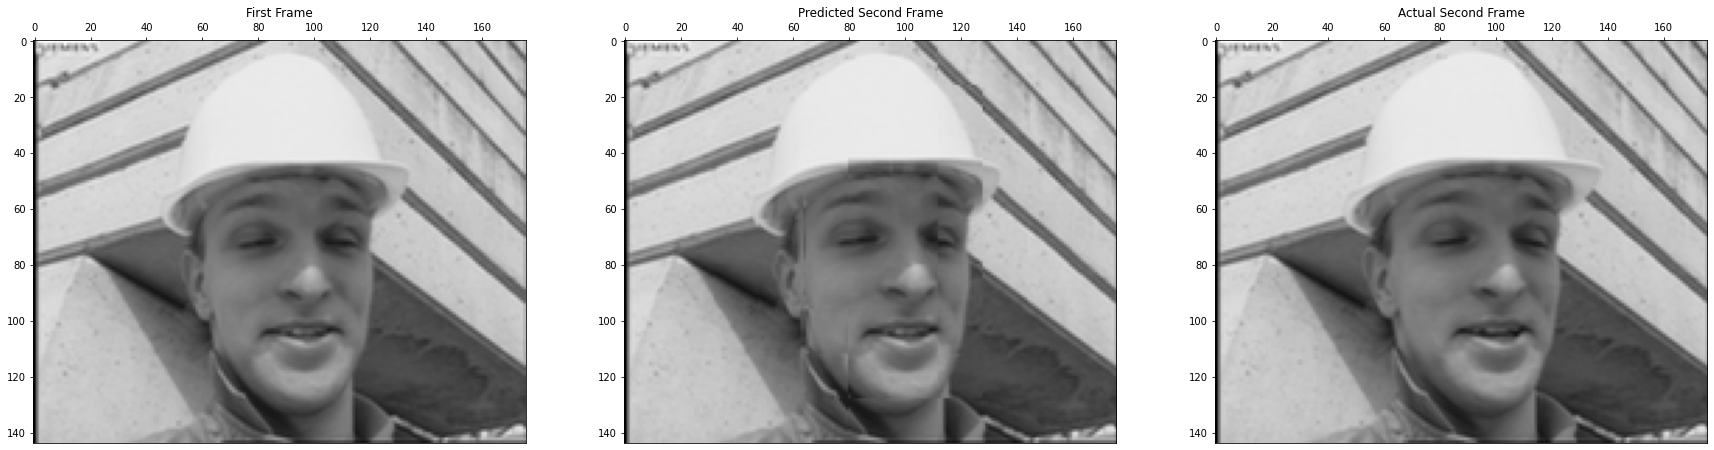

In [13]:
plt.figure(figsize=(30,20))

plt.subplot(1,3,1)
plt.title('First Frame')
plt.imshow(I[0],cmap='gray')

plt.subplot(1,3,2)
plt.title('Predicted Second Frame')
plt.imshow(PredFrame,cmap='gray')

plt.subplot(1,3,3)
plt.title('Actual Second Frame')
plt.imshow(I[1],cmap='gray')

plt.show()

### Error between the Second Frame and its Motion Compensated Predicted version

In [14]:
def Error(Pred,Actual):
    return MAD((Pred*255).astype(int),(Actual*255).astype(int))

Error(PredFrame,I[1])

2.956912878787879

#### Displaying Results

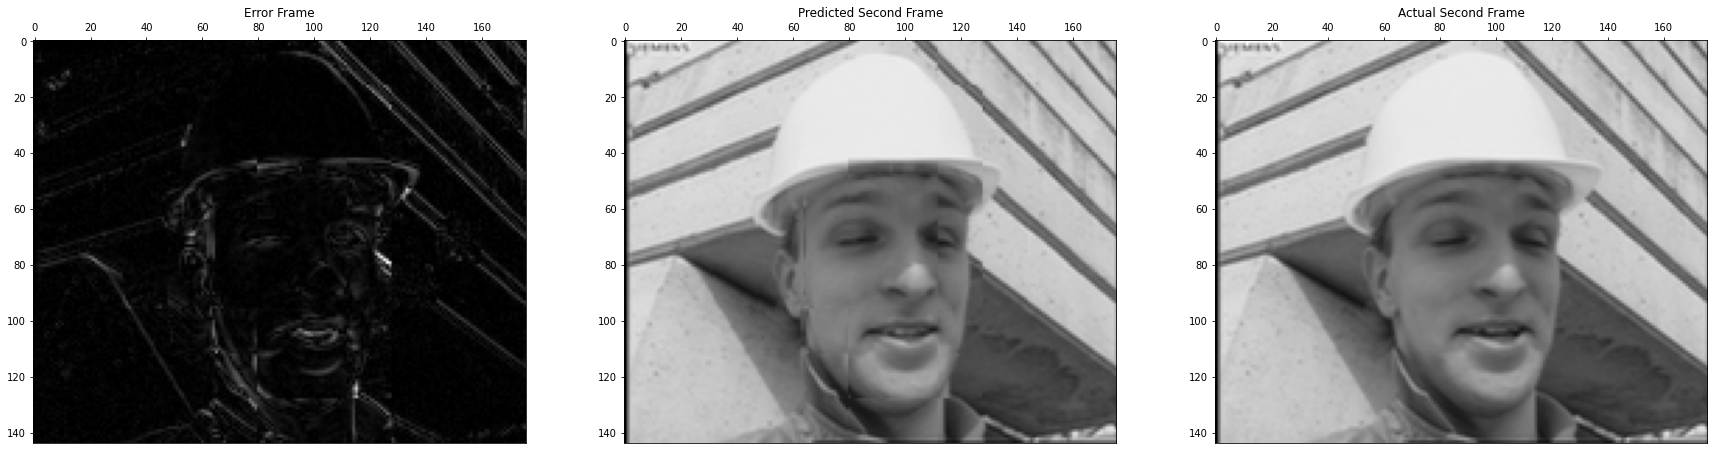

In [15]:
plt.figure(figsize=(30,20))

plt.subplot(1,3,1)
plt.title('Error Frame')
plt.imshow(np.abs(PredFrame-I[1]),cmap='gray')

plt.subplot(1,3,2)
plt.title('Predicted Second Frame')
plt.imshow(PredFrame,cmap='gray')

plt.subplot(1,3,3)
plt.title('Actual Second Frame')
plt.imshow(I[1],cmap='gray')

plt.show()